## Sales & Prices - CompuStat

CompuStat guide: https://crsp.org/files/ccm_data_guide_0.pdf

Sectors in CompuStat CRSP:
>Acronym for Global Industry Classification Standard codes. These codes are
a result of a collaboration between Standard & Poor’s and Morgan Stanley
Capital International and are based upon a hierarchy of economic sectors,
which can be further divided into industry groups, industries and subindustries. Economic sectors have a two-digit identification code, industry
groups have a four-digit identification code, industries have a six-digit
identification code and sub-industries have an eight-digit identification code

In [1]:
import numpy as np
import pandas as pd
import scipy.stats
import math
import matplotlib.pyplot as plt

# System files 
import sys
sys.path.append('..')  # now I'm in the parent directory

from src.random_matrix import *
from src.csv_data.to_clean import *
from src.csv_data.utils import *
from src.funcs import *
from src.export import *
from src.synthetic import *

# Plotting
%matplotlib inline
plt.rcParams["figure.figsize"] = [13,13]  # Set default figure size

import seaborn as sns  # Latex Plots
sns.set_style('ticks') 

- Sales & Prices data for companies
- GICS Sectors for each company 

In [2]:
path_clean_s = '/Users/pietrobicocchi/Desktop/project/data/cleaned/CompStat_sales.pkl'
path_clean_p = '/Users/pietrobicocchi/Desktop/project/data/cleaned/CompStat_prices.pkl'

# Load the saved DataFrame
returns_sales = pd.DataFrame(load_cleaned_data(path_clean_s))
returns_prices = pd.DataFrame(load_cleaned_data(path_clean_p))

In [29]:
gvkeys = list(returns_sales.columns)  # list of gvkeys of my sales data

sectors = extract_data('/Users/pietrobicocchi/Desktop/project/' + 'data/CompStat/sectors.csv')
key_to_sect = get_unique_sectors(sectors)
key_sect = gvkeys_to_sect(gvkeys, key_to_sect)
idx_by_sector, sector_dict, sector_indices, sector_labels = create_sectors(key_sect)

/Users/pietrobicocchi/Desktop/project/notebooks/../src/csv_data/utils.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sectors["datadate"] = pd.to_datetime(sectors["datadate"])
/Users/pietrobicocchi/Desktop/project/notebooks/../src/csv_data/utils.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sectors['gsector'] = sectors['gsector'].fillna(1)
/Users/pietrobicocchi/Desktop/project/notebooks/../src/csv_data/utils.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [4]:
# Numebers of gvkeys that are not contained into the dictionary -> assigned as others:
i=0
for key in gvkeys:
    try:
        sec = key_to_sect.loc[key]['sector_name']
        #print(sec)
        key_sect.append(sec)
    except KeyError:
        # Handle the KeyError condition here
        #print(f"KeyError occurred for key: {key}")
        i+=1
        key_sect.append('Other')  # or add a default value to the list
        
i #189 companies has been sectorized as Other since they didn't have a sector code. 

189

## Sales

### correlations

In [5]:
%%time
corr_sales = returns_sales.corr(method= 'pearson', min_periods=8)
corr_sales = corr_sales.replace([np.nan, np.inf, -np.inf], 0)

corr_prices = returns_prices.corr(method= 'pearson', min_periods=8)
corr_prices = corr_prices.replace([np.nan, np.inf, -np.inf], 0)

CPU times: user 747 ms, sys: 21.4 ms, total: 768 ms
Wall time: 769 ms


In [6]:
corr_prices

GVKEY,1004,1045,1050,1062,1072,1075,1076,1078,1104,1121,...,15106,15247,16668,16775,17072,17073,17252,19605,19661,20029
GVKEY,,,,,,,,,,,,,,,,,,,,,
1004,1.000000,0.522063,0.192853,0.033588,0.466924,0.127533,0.058621,0.159648,0.206380,0.257697,...,0.202339,0.303084,0.248129,-0.099105,0.212780,0.336766,0.193078,-0.068961,0.305026,0.234679
1045,0.522063,1.000000,0.244279,-0.110628,0.343027,0.283637,0.188838,0.155764,0.208545,0.165574,...,0.229818,0.247658,0.167687,-0.025213,0.127255,0.402691,0.200485,0.013651,0.222001,0.352409
1050,0.192853,0.244279,1.000000,-0.028821,0.127954,0.255608,0.172023,-0.069143,0.228892,0.213130,...,0.127723,0.207770,0.259941,-0.101775,0.019868,0.547689,0.131698,0.213060,0.172116,0.252634
1062,0.033588,-0.110628,-0.028821,1.000000,0.138194,-0.145910,0.048768,0.150372,0.113772,0.103447,...,-0.056815,0.021933,-0.019104,0.001870,0.039610,0.015186,-0.129643,0.085363,0.075445,0.032523
1072,0.466924,0.343027,0.127954,0.138194,1.000000,0.003467,0.026264,0.090592,0.209695,0.264154,...,0.162520,0.272832,-0.092278,0.047248,0.047563,0.070659,0.007505,0.137039,0.234109,-0.005178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17073,0.336766,0.402691,0.547689,0.015186,0.070659,0.410086,0.303415,0.147421,0.309662,0.249044,...,0.163748,0.447099,0.226223,-0.101505,0.097631,1.000000,0.365458,0.072148,0.091861,0.345055
17252,0.193078,0.200485,0.131698,-0.129643,0.007505,0.099619,0.156439,0.077242,0.181494,0.070536,...,0.022886,0.537976,0.135549,0.012932,0.125936,0.365458,1.000000,-0.208168,-0.004943,0.131021
19605,-0.068961,0.013651,0.213060,0.085363,0.137039,0.037189,0.092931,0.031704,0.196367,0.171104,...,0.077223,0.026071,-0.129801,0.063986,-0.002249,0.072148,-0.208168,1.000000,0.110198,-0.055899


In [7]:
%%time
eVal_s , eVec_s = getPCA(corr_sales)
eVal_p , eVec_p = getPCA(corr_prices)

CPU times: user 604 ms, sys: 32.3 ms, total: 637 ms
Wall time: 168 ms


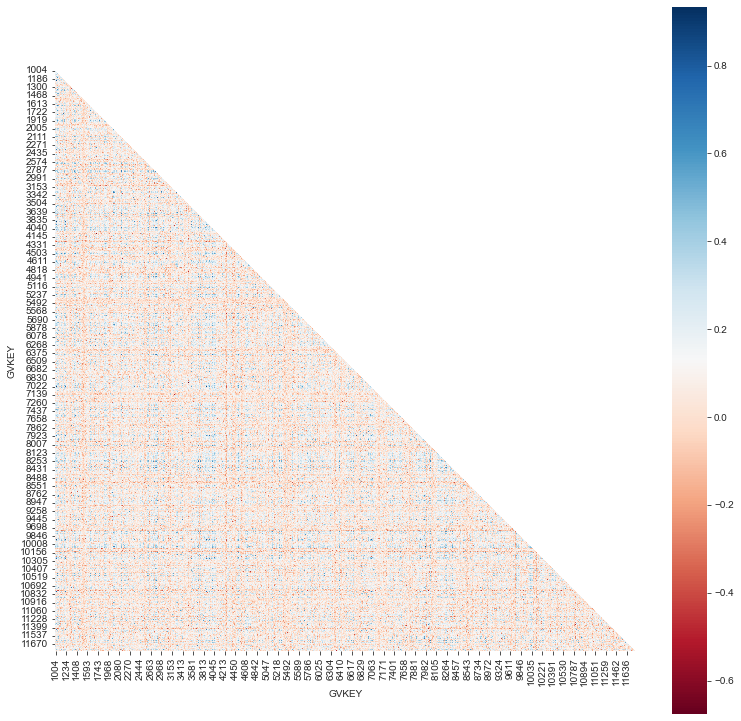

In [8]:
# Create a mask to hide some cells
mask = np.zeros_like(corr_sales)
mask[np.triu_indices_from(mask)] = True
colormap = plt.cm.RdBu

# Create the heatmap with the mask
sns.heatmap(corr_sales, mask=mask, cmap=colormap, square=True, annot=False)

# Show the plot
plt.show()

- Marcenko-Pastur distribution for eigenvalues

/var/folders/x6/85hsl6vd4xn8qtg06p6gf4j80000gn/T/ipykernel_52608/1576557803.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


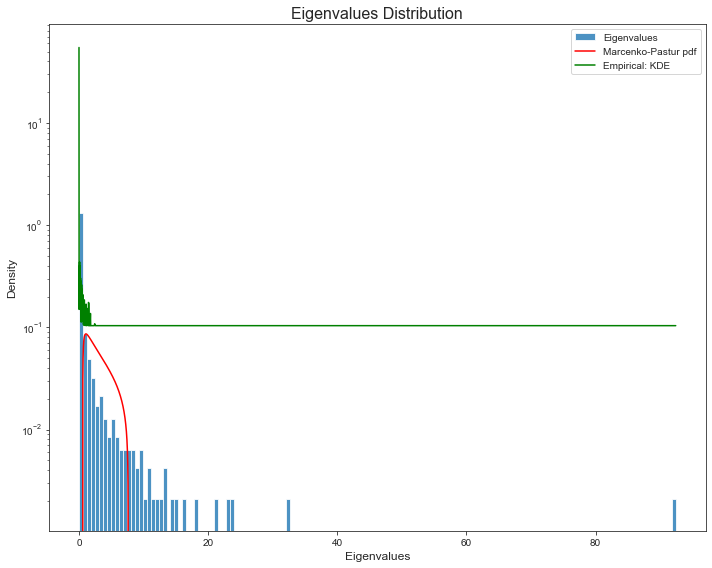

In [9]:
fig = visualize_pm_eig(returns_sales.shape[1], returns_sales.shape[0], eVal_s)
fig.show()

- modes

/var/folders/x6/85hsl6vd4xn8qtg06p6gf4j80000gn/T/ipykernel_52608/4215702306.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


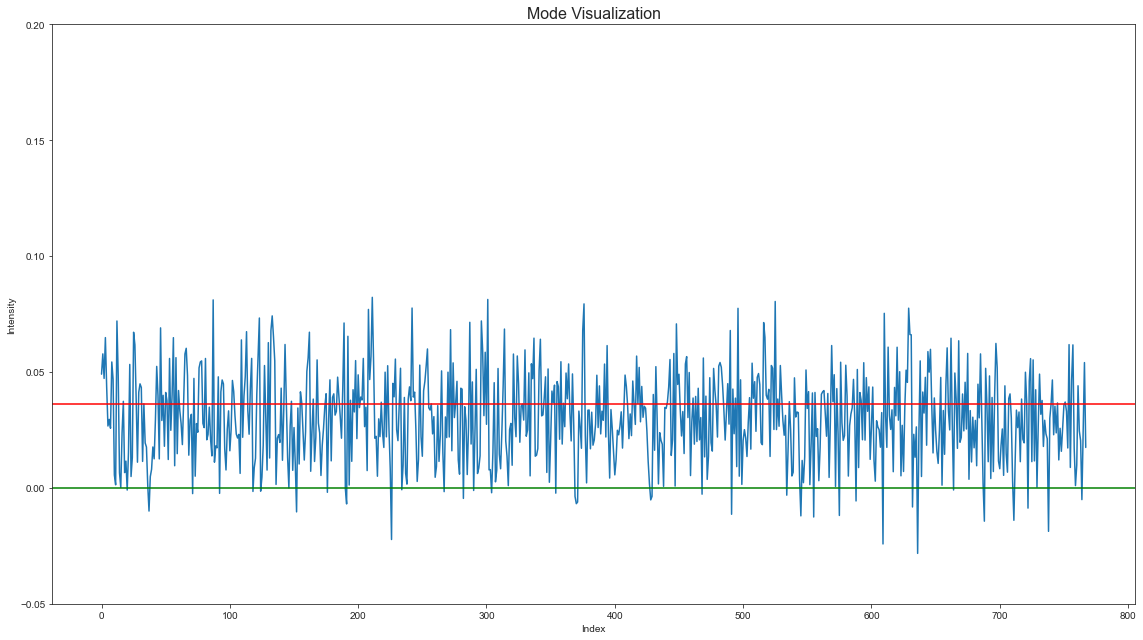

In [10]:
fig = visualize_mode(eVec = eVec_s, corr = corr_sales, mode = -1)
fig.show()

/var/folders/x6/85hsl6vd4xn8qtg06p6gf4j80000gn/T/ipykernel_52608/300541810.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


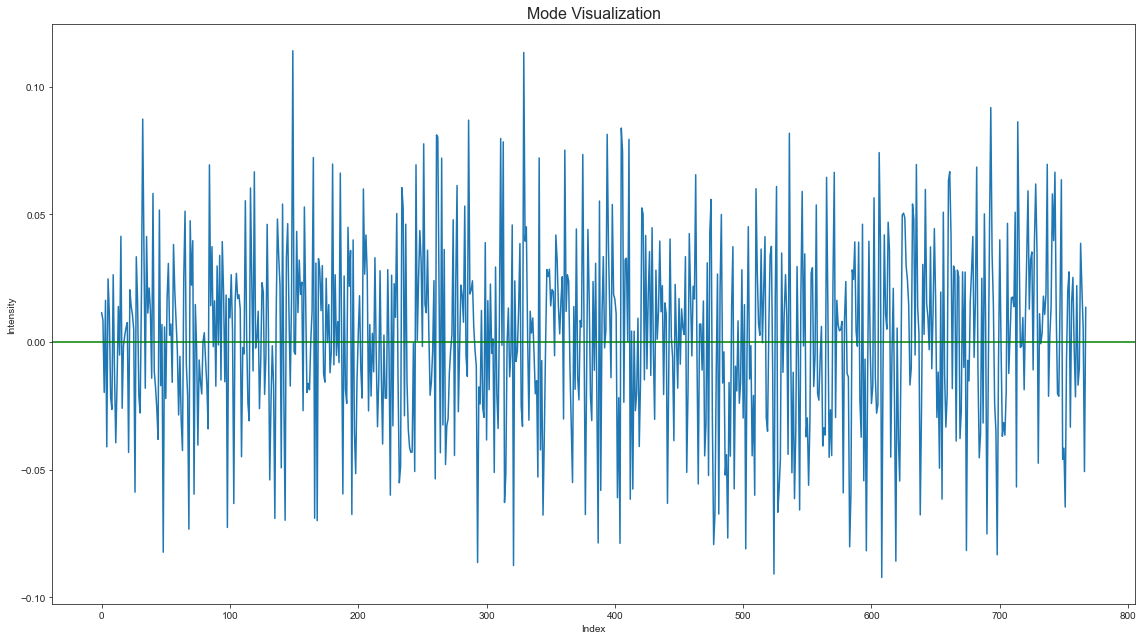

In [11]:
fig = visualize_mode(eVec = eVec_s, corr = corr_sales, mode = -2)
fig.show()

/var/folders/x6/85hsl6vd4xn8qtg06p6gf4j80000gn/T/ipykernel_52608/3264894795.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


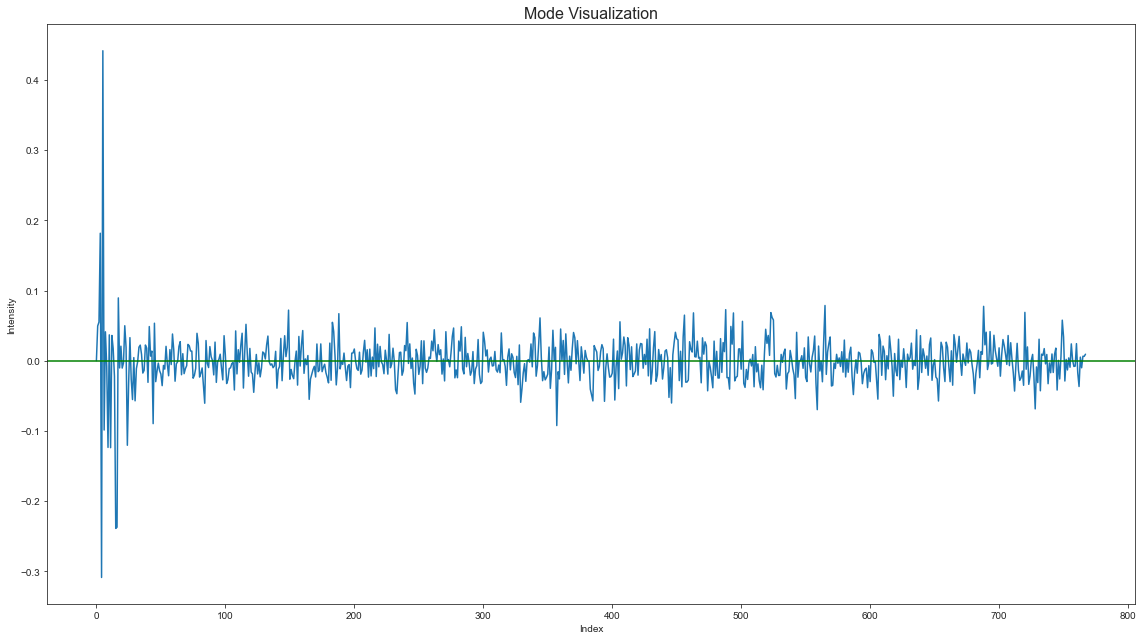

In [12]:
fig = visualize_mode(eVec = eVec_s, corr = corr_sales, mode = 0)
fig.show()

- Plotting mode by sectors

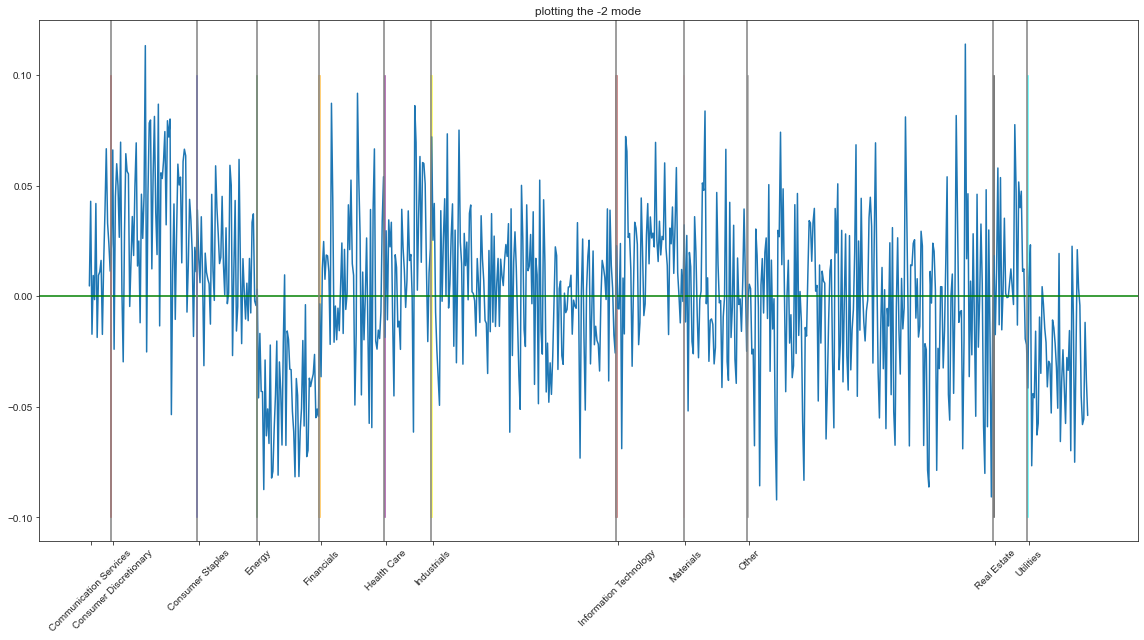

In [34]:
#plt.plot(eVec_s[idx_by_sector, -1].flatten())
plot_by_sector(mode=-2, tk_ind = key_sect, eVec = eVec_s)

- Density of eigenvectors

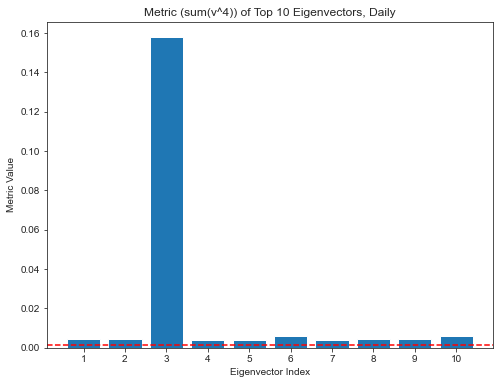

In [16]:
metric = density_eigenvector_metric(eigenvectors = eVec_s, number_eVec=10)

# Plot the metric values
plt.figure(figsize=(8, 6))
plt.bar(range(1, 11), metric)
plt.xlabel('Eigenvector Index')
plt.ylabel('Metric Value')
plt.title('Metric (sum(v^4)) of Top 10 Eigenvectors, Daily')
plt.xticks(range(1, 11))

plt.axhline(y=1/(len(eVec_s)), color='red', linestyle='--')

plt.show()

- mode coefficients

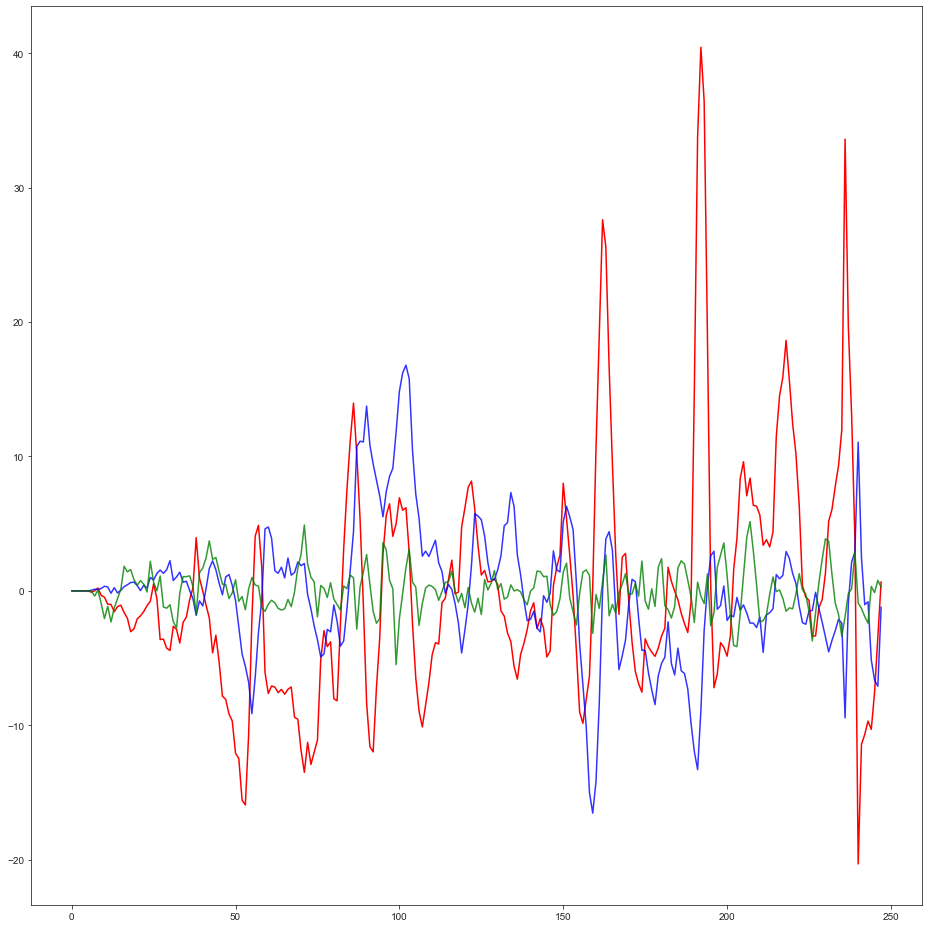

In [17]:
plt.rcParams["figure.autolayout"] = True
pl1=plt.plot(mode_coefficient(returns_sales, 0), alpha=1, color='r')
pl2=plt.plot(mode_coefficient(returns_sales, 1), alpha =0.8, color='b')
pl3=plt.plot(mode_coefficient(returns_sales, 60), alpha =0.8, color='g')

plt.show()

tells you how much every mode is significant at each instant in time

/var/folders/x6/85hsl6vd4xn8qtg06p6gf4j80000gn/T/ipykernel_52608/3466436172.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


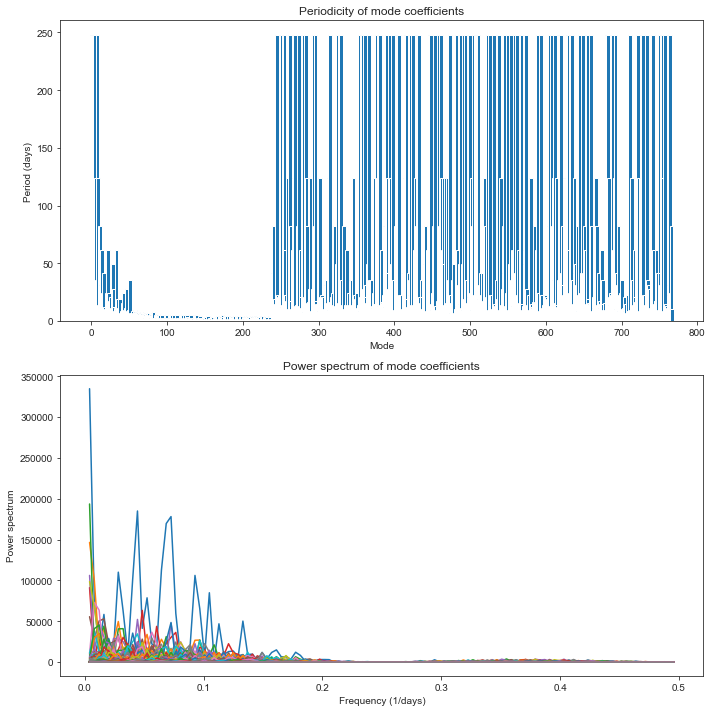

In [40]:
periods, power_spectra = analyze_mode_coefficients(returns_sales)
fig = plot_mode_analysis(periods, power_spectra, returns_sales)
fig.show()

In [50]:
print(f"the period of the first mode is: {periods[0]}")
print(f"the period of the second mode is: {periods[1]}")

the period of the first mode is: 248.0
the period of the second mode is: 248.0


I don't like this result. Why this peak at low frequency and consequently the majority of the periods hit the T = 248, i.e. the length of the time series. A reason could be the Spectral leakage problem.

https://fischerbach.medium.com/introduction-to-fourier-analysis-of-time-series-42151703524a

In [19]:
# Testing the function:
x = np.linspace(0,100,num= 1000)
y1 = np.sin(x)
y2 = np.cos(x)
y3 = np.cos(np.cos(x))
data0 = {}

for key in range(50):
    data0[str(key)] = np.sin(x)
    
y = pd.DataFrame(data0)

/Users/pietrobicocchi/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/pietrobicocchi/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/pietrobicocchi/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/pietrobicocchi/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/pietrobicocchi/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:501: RuntimeWarning: invalid value

/Users/pietrobicocchi/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/pietrobicocchi/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/pietrobicocchi/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/pietrobicocchi/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/pietrobicocchi/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:501: RuntimeWarning: invalid value

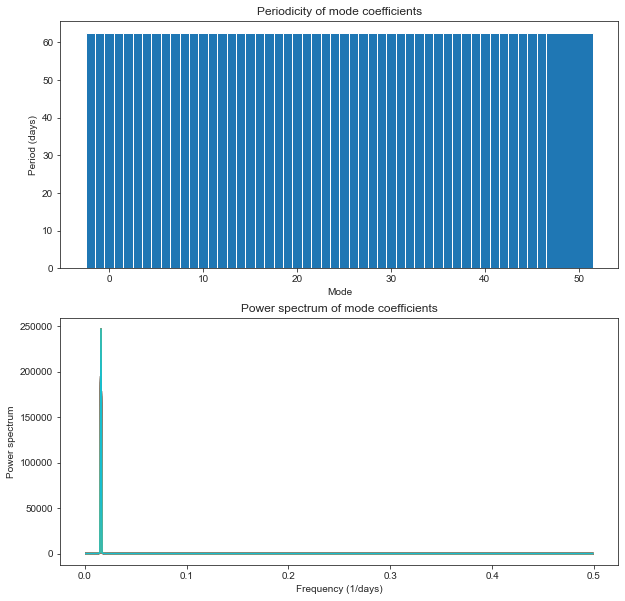

In [77]:
periods0, power_spectra0 = analyze_mode_coefficients(y)
fig = plot_mode_analysis(periods0, power_spectra0, y)
fig.show()

### Lead-lag correlations

In [37]:
lagged_corr=lagged_correlation(returns_sales, tau = 50)
lagged_corr

GVKEY,1004,1045,1062,1072,1075,1076,1078,1104,1121,1161,...,11669,11670,11672,11687,13003,13714,14253,15106,15247,28590
GVKEY,,,,,,,,,,,,,,,,,,,,,
1004,0.0882,-0.2012,0.0876,0.0215,-0.0166,-0.1139,0.1753,-0.185,-0.0862,-0.0273,...,0.0003,-0.0123,-0.0785,0.0328,0.1094,0.2451,0.0591,0.008,-0.1684,0.1242
1045,-0.0267,-0.0554,0.0227,0.0355,0.0295,-0.0108,0.0289,-0.0422,0.0259,0.0039,...,0.0224,0.001,-0.0143,0.0178,0.0254,0.007,0.0351,-0.0038,-0.0141,0.0151
1062,-0.0435,-0.0934,-0.0038,-0.0054,0.0522,-0.0859,-0.1526,-0.0706,0.0169,-0.1073,...,0.0595,0.0848,0.0456,-0.0726,-0.0103,0.0054,0.0217,-0.0342,-0.2981,0.082
1072,-0.0025,-0.0983,0.0856,0.0684,0.1936,-0.1267,-0.15,-0.0661,0.1736,-0.1005,...,0.0536,0.0184,0.0243,0.0944,0.0969,0.0691,0.1249,-0.1199,-0.0297,0.0351
1075,0.1489,0.0012,0.0617,0.0251,0.0434,-0.0189,-0.131,-0.2089,-0.0044,-0.1025,...,-0.028,-0.0278,-0.0324,-0.0703,0.1318,0.1266,-0.0052,-0.0213,-0.0116,-0.0161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13714,0.122,-0.0375,0.0247,-0.0179,-0.0089,0.0394,-0.1162,-0.0892,0.0375,-0.0764,...,-0.1116,-0.005,-0.0284,0.139,-0.0573,0.0216,-0.0419,0.0138,-0.0808,0.1352
14253,0.1216,0.2116,-0.1541,-0.0557,-0.0572,0.0382,-0.0258,-0.1368,0.0758,-0.0944,...,-0.0528,0.0283,0.0746,-0.0641,0.0712,-0.0669,-0.0517,-0.0562,0.0423,-0.0071
15106,0.0347,-0.056,-0.0177,0.062,0.0424,-0.1444,0.074,-0.0613,0.0883,0.0745,...,0.0041,-0.0157,-0.0072,-0.1032,0.0547,0.0485,0.0073,-0.0142,-0.1346,0.0358


In [38]:
lagged_corr = lagged_corr.replace([np.nan, np.inf, -np.inf], 0)
u, s, v = np.linalg.svd(lagged_corr.values) 

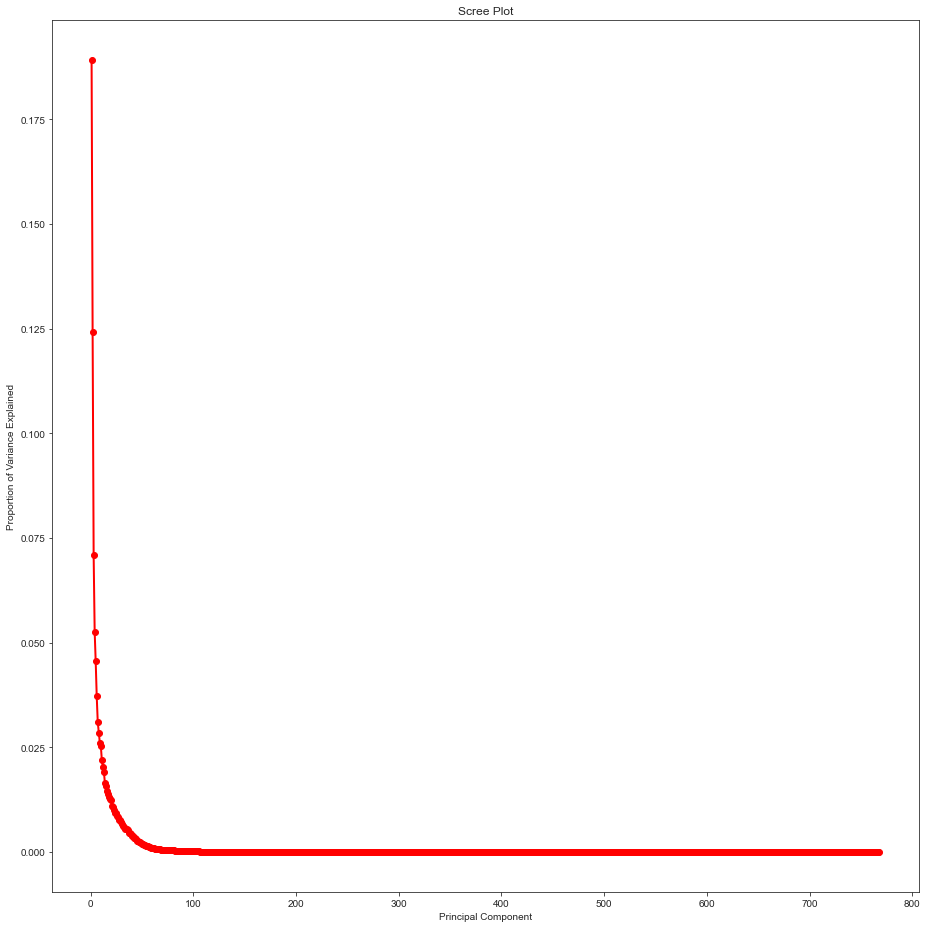

In [39]:
# Calculate the proportion of variance explained by each principal component
variance_explained = (s ** 2) / np.sum(s ** 2)

# Plot the variance explained
plt.plot(np.arange(1, len(variance_explained)+1), variance_explained, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

### Synthetic time series

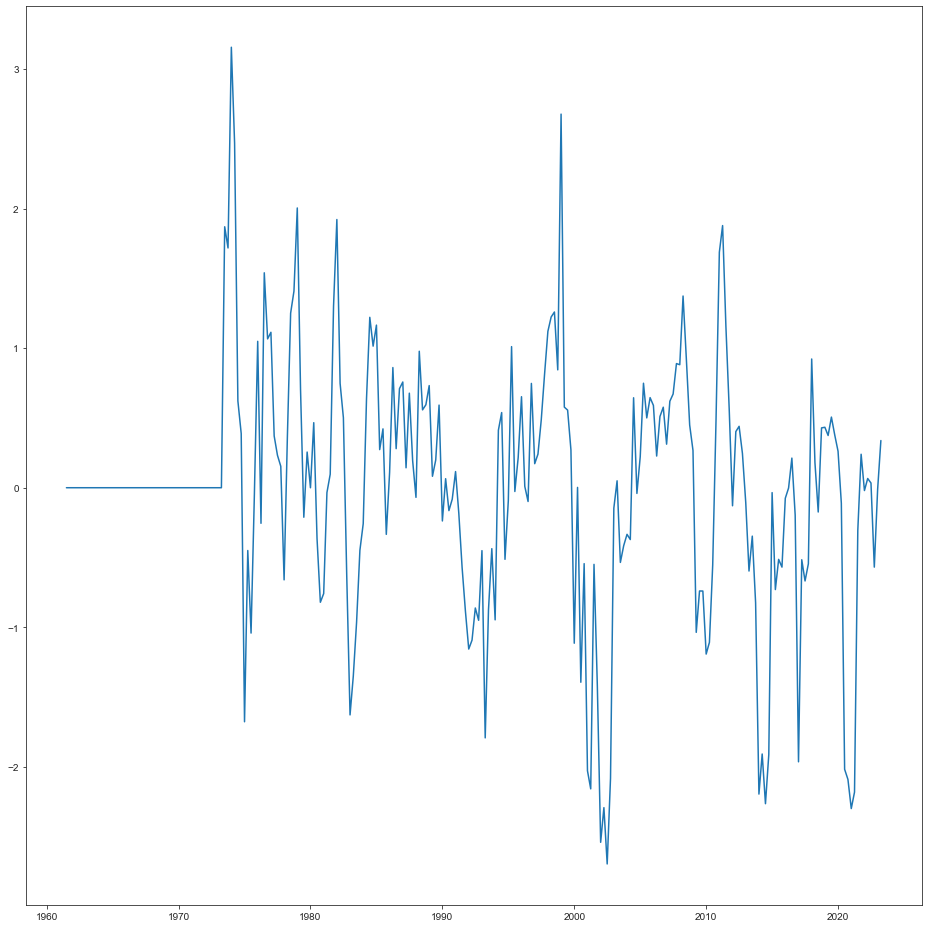

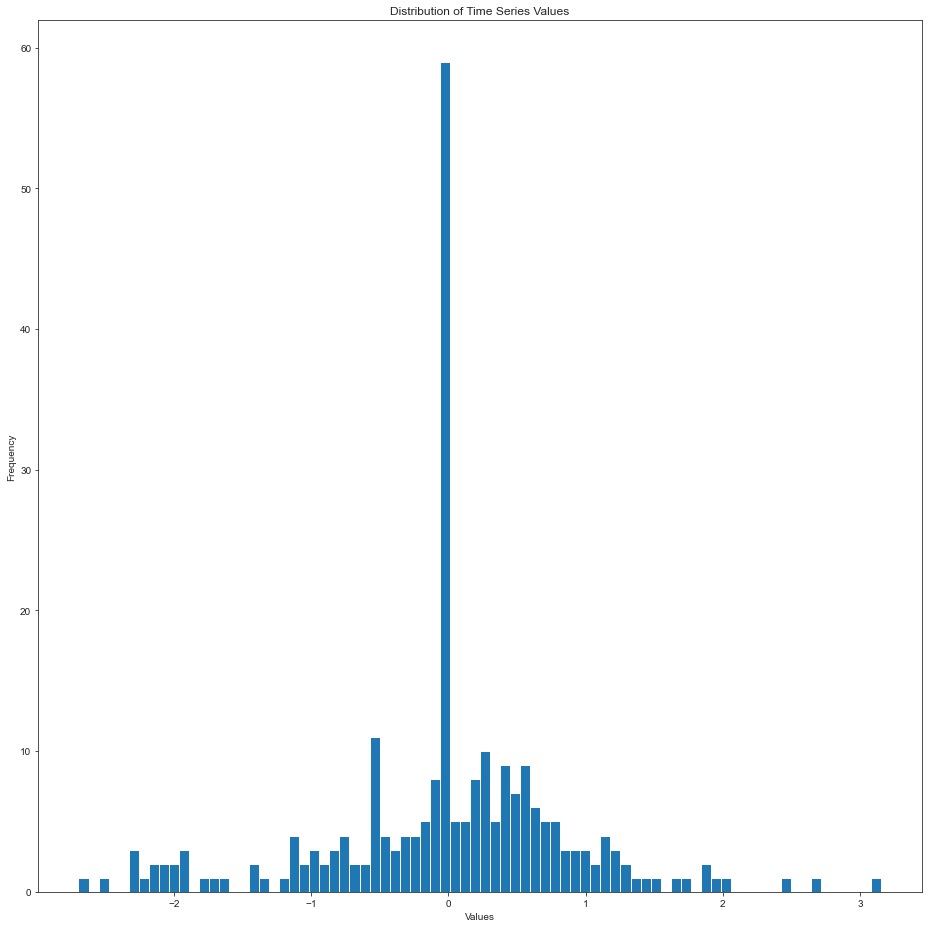

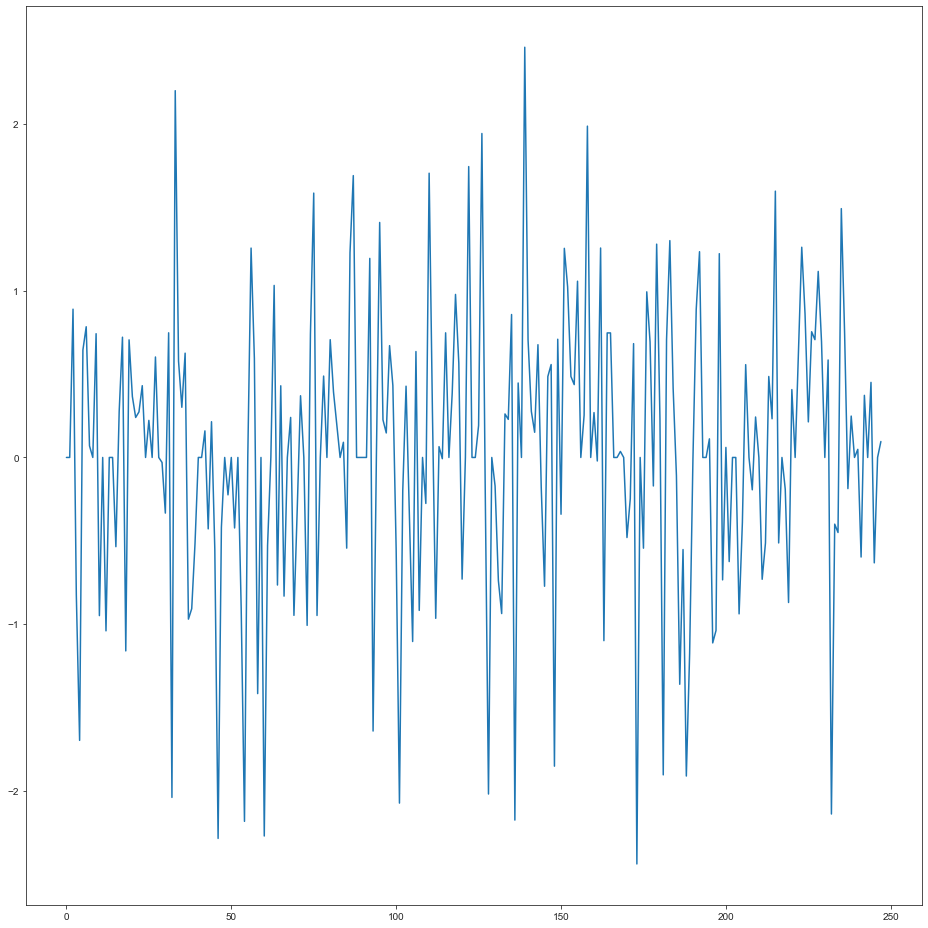

In [20]:
plt.plot(returns_sales[1004])
plot_distribution(returns_sales[1004])
synthetic_time_series = generate_sample_time_series(returns_sales[1004])
plt.plot(synthetic_time_series)

- Sampling

/Users/pietrobicocchi/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


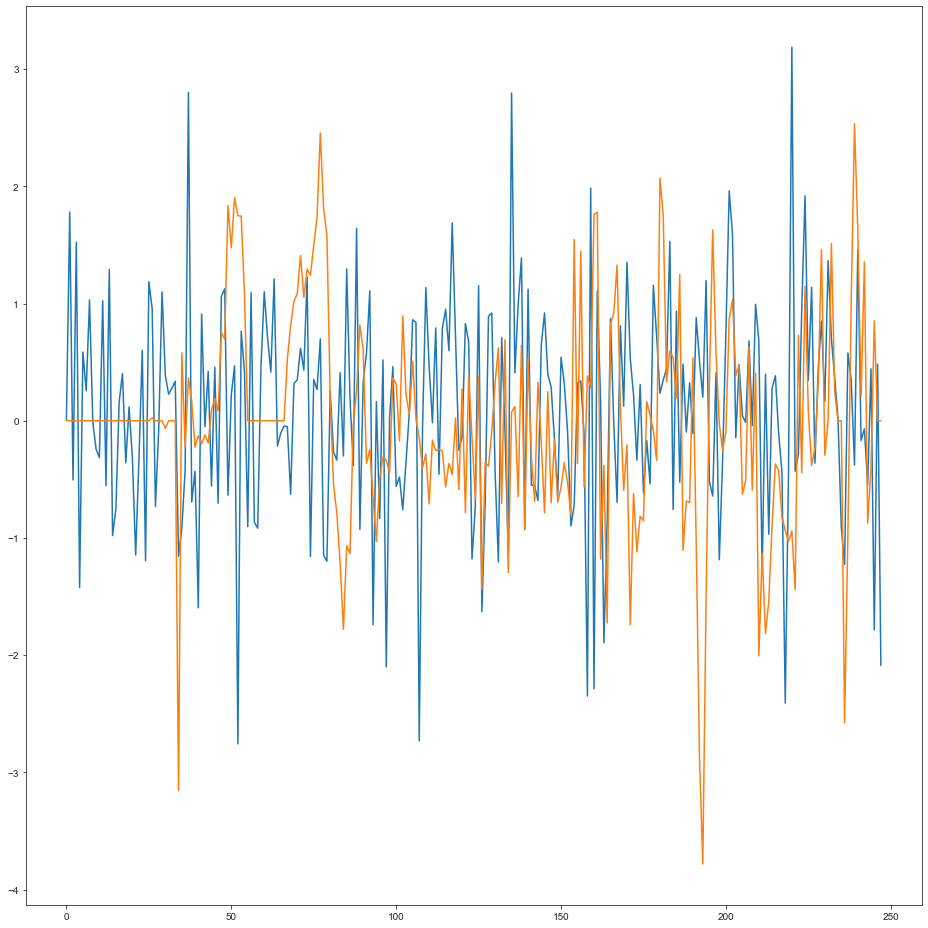

In [21]:
returns_syn = synthetic_returns_sampling(returns_sales, eVec_s)

# Example
plt.plot(returns_syn[:,2])
plt.plot(returns_sales[1062].values)

In [22]:
returns_syn = pd.DataFrame(returns_syn)
corr_sy = returns_syn.corr(method= 'pearson', min_periods=8)
corr_sy

/Users/pietrobicocchi/opt/anaconda3/lib/python3.9/site-packages/pandas/core/internals/managers.py:1587: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = arr.astype(dtype, copy=False)


,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,1.000000,-0.047487,0.045703,0.036385,0.023425,0.046144,-0.089453,-0.040188,0.076216,-0.035805,...,0.147780,-0.123563,0.036168,-0.037444,-0.093279,0.005521,0.090530,0.108902,0.072754,0.071069
1,-0.047487,1.000000,0.045224,0.059776,-0.234490,0.258379,-0.260208,0.049312,0.202804,-0.139123,...,-0.145651,-0.072486,0.065929,0.117553,-0.148872,0.085252,-0.075511,-0.012121,-0.025649,0.212994
2,0.045703,0.045224,1.000000,0.134108,-0.324873,0.367780,0.034501,-0.366698,-0.125100,-0.215706,...,-0.068611,-0.002443,0.171472,0.021515,-0.249589,-0.151973,0.030969,-0.063652,0.028561,0.181910
3,0.036385,0.059776,0.134108,1.000000,-0.750530,0.333886,-0.180040,0.018633,0.138430,-0.297729,...,0.148557,-0.023539,0.304047,-0.112922,-0.172673,0.119663,-0.181941,0.062031,0.004613,-0.164362
4,0.023425,-0.234490,-0.324873,-0.750530,1.000000,-0.594315,0.453231,-0.053741,-0.156709,0.345490,...,0.003728,0.053304,-0.325557,0.188001,0.375598,-0.195062,0.188097,-0.071379,-0.004793,-0.011660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,0.005521,0.085252,-0.151973,0.119663,-0.195062,0.070216,-0.034852,0.009013,0.039488,0.036654,...,0.089626,0.102454,0.067009,-0.264281,-0.114924,1.000000,-0.132330,-0.011362,0.116917,0.069854
764,0.090530,-0.075511,0.030969,-0.181941,0.188097,-0.049370,0.002830,0.013673,-0.184301,-0.025863,...,-0.002386,0.022017,-0.126066,-0.094421,0.106265,-0.132330,1.000000,-0.070790,-0.047600,0.298545
765,0.108902,-0.012121,-0.063652,0.062031,-0.071379,0.247620,-0.022585,0.007271,0.203819,-0.192573,...,-0.267022,-0.002499,0.053852,0.040990,-0.211472,-0.011362,-0.070790,1.000000,-0.082762,0.042755
766,0.072754,-0.025649,0.028561,0.004613,-0.004793,-0.023907,0.090066,-0.077512,-0.030429,-0.015808,...,0.008141,-0.004757,0.052475,-0.195175,-0.127897,0.116917,-0.047600,-0.082762,1.000000,0.043661


In [23]:
distance = []
for _ in range(100):
    returns_syn = synthetic_returns_sampling(returns_sales, eVec_s)
    returns_syn = pd.DataFrame(returns_syn)
    corr_sy = returns_syn.corr(method= 'pearson', min_periods=8)
    eVal_sy , eVec_sy = getPCA(corr_sy)

    distance.append(spectral_distance_metric(eVec_s, eVec_sy, n=15))

/Users/pietrobicocchi/opt/anaconda3/lib/python3.9/site-packages/pandas/core/internals/managers.py:1587: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = arr.astype(dtype, copy=False)


------

In order to compute the distance between the eigenspace of the same companies share prices instead of the sales. We should import the same data paying heet to keep the same companies data.



In [24]:
import src.csv_data.extract as ex
df = ex.extract_data('/Users/pietrobicocchi/Desktop/project/' + 'data/CompStat/crsp_ccm_inventories_sales.csv')
sales, prices = df_to_sales(df)

In [25]:
sales_keys = returns_sales.keys()
tailored_prices = tailored_clean(prices, sales_keys)
tailored_prices

corr_tail_sales = tailored_prices.corr(method= 'pearson', min_periods=8)
eVal_tail_p , eVec_tail_p = getPCA(corr_tail_sales)

/Users/pietrobicocchi/opt/anaconda3/lib/python3.9/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


In [26]:
distance_sales_prices = spectral_distance_metric(eVec_s, eVec_tail_p, n=15)

------

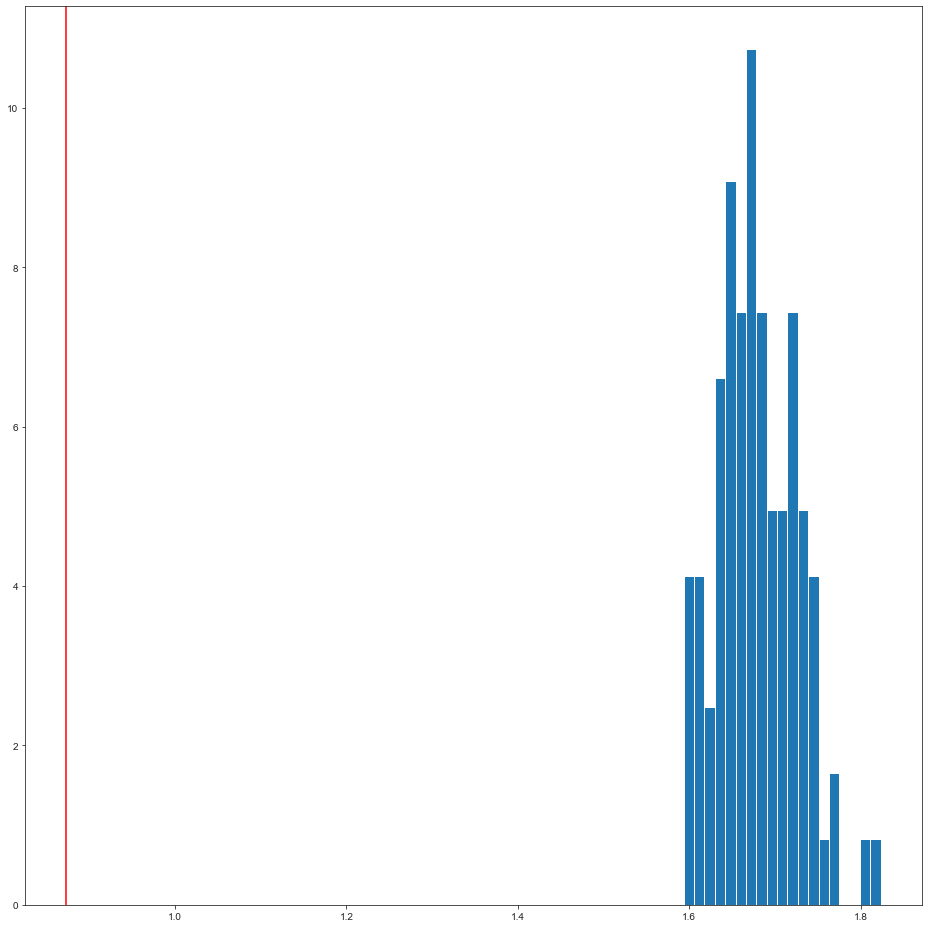

In [27]:
plt.hist(distance, bins = np.linspace(np.min(distance), np.max(distance), 20), density=True)
plt.axvline(distance_sales_prices, color='r')

I'm plotting a vertical line for the sales-prices eigenspace distance. (it should be measured for the same companies)

two cases 
> if the line is outside the distribution we can safely assume that the sales and the prices have different generative processes 

> if the line is inside the distribution, it could be a sign of the fact that sales and prices have the same generative process

- Shuffling

To cast the problem in a linear algebra fashion, let's define the given information and steps using matrices and vectors.

1. Returns Time Series:
Let's say we have a returns time series represented as a matrix, denoted by X. Each column of X represents the returns of a specific asset or variable, and each row represents a different time period. So, X has dimensions N x M, where N is the number of time periods and M is the number of assets/variables.

2. Sample Correlation Matrix:
We compute the sample correlation matrix, denoted by C, by calculating the correlation coefficients between the returns of all pairs of assets. C is an M x M square matrix, where each entry C(i, j) represents the correlation between the ith and jth assets.

3. Eigendecomposition:
We perform the eigendecomposition of the correlation matrix C, which gives us a set of eigenvectors and eigenvalues. Let's denote the eigenvectors as V and the eigenvalues as λ. V is an M x M matrix, where each column represents an eigenvector, and λ is an M-dimensional vector containing the eigenvalues.

4. Projection onto Eigenspace:
We project the returns time series (X) onto the eigenspace spanned by the eigenvectors V. This projection yields a new matrix Y, which represents the coordinates of the returns time series in the eigenspace. Y is obtained by multiplying X with V, i.e., Y = X * V.

5. Shuffle Projection Components:
For each mode (eigenvalue-eigenvector pair), we shuffle the components of the projection matrix Y. Let's denote the shuffled projection matrix as Y_shuffle.

6. Generate Synthetic Time Series:
To generate synthetic time series, we reconstruct the shuffled projection matrix Y_shuffle using the eigenvectors V. Let's denote the reconstructed matrix as X_synthetic, which has the same dimensions as the original returns time series X.

7. Recompute Correlation Matrix:
Finally, we recompute the correlation matrix for the synthetic time series X_synthetic, obtaining a new correlation matrix C_synthetic.

In summary, we have:

Original Data:
Returns Time Series: X (N x M)
Correlation Matrix: C (M x M)

Eigendecomposition:
Eigenvectors: V (M x M)
Eigenvalues: λ (M-dimensional vector)

Projection onto Eigenspace:
Projected Matrix: Y = X * V (N x M)

Shuffle Projection Components:
Shuffled Projection Matrix: Y_shuffle (N x M)

Synthetic Time Series:
Reconstructed Matrix: X_synthetic = Y_shuffle * V^T (N x M)

Recomputed Correlation Matrix:
Correlation Matrix for Synthetic Time Series: C_synthetic (M x M)

Note that the eigenvectors are typically orthogonal, which allows us to reconstruct the synthetic time series by multiplying the shuffled projection matrix by the transposed eigenvectors. This assumes that the eigenvectors form an orthonormal basis.

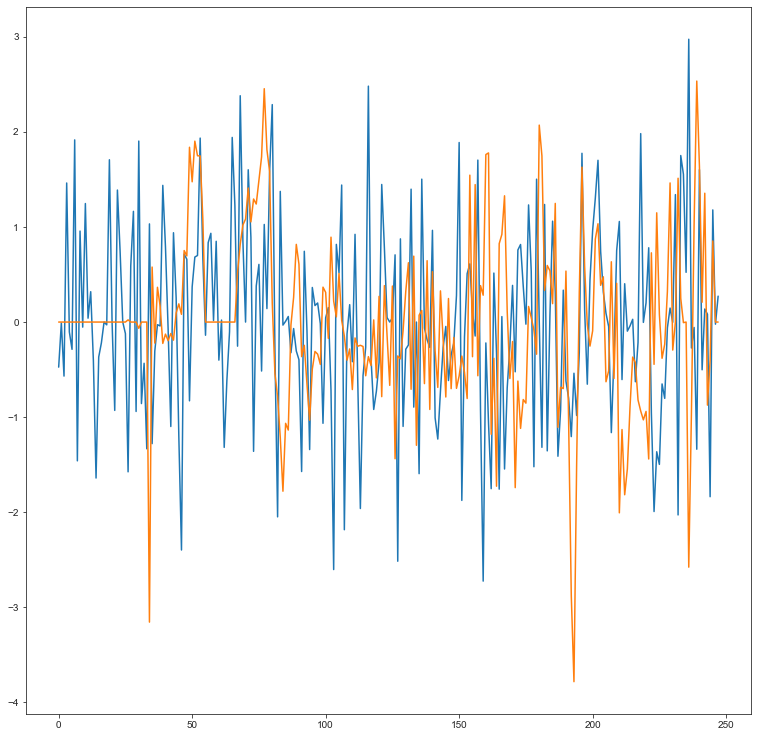

In [397]:
returns_syn = synthetic_returns_shuffling(returns_sales, eVec_s)

# Example
plt.plot(returns_syn[:,2])
plt.plot(returns_sales[1062].values)

the synthetic series generated using the shuffled projection components and reconstructed using eigenvectors should exhibit similar correlation structure and preserve some statistical properties of the original data. However, it may not capture specific patterns or details that are not explained by the major modes of correlation captured by the eigenvectors. The extent of similarity between the synthetic series and the original data will depend on the number of eigenvectors used and their corresponding eigenvalues, as well as the nature of the data and the specific patterns present in it.

In [398]:
returns_syn = pd.DataFrame(returns_syn)
corr_sy = returns_syn.corr(method= 'pearson', min_periods=8)
corr_sy

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,1.000000,-0.021962,-0.209675,0.099395,0.145629,-0.182671,0.150800,-0.310889,0.295280,0.048812,...,0.063209,-0.087953,0.024418,-0.041941,-0.063984,0.084503,-0.055556,0.012629,0.114361,-0.080040
1,-0.021962,1.000000,0.031456,0.046177,-0.080685,0.230251,-0.179993,0.052932,0.059834,0.035028,...,-0.014643,-0.070736,0.020907,0.003600,-0.089217,0.013507,-0.031094,0.007410,0.002764,0.281939
2,-0.209675,0.031456,1.000000,0.213763,-0.505642,0.464322,-0.018508,-0.268882,-0.190941,-0.267926,...,-0.040639,-0.004995,0.133966,-0.007722,-0.253980,-0.155607,0.040970,-0.114565,-0.044553,0.175427
3,0.099395,0.046177,0.213763,1.000000,-0.717008,0.340644,-0.067014,-0.001920,0.116699,-0.278504,...,0.096735,-0.052596,0.188539,-0.198809,-0.212572,0.118178,-0.102623,0.036285,0.070301,0.002941
4,0.145629,-0.080685,-0.505642,-0.717008,1.000000,-0.585867,0.317205,-0.030752,-0.038312,0.320816,...,-0.021704,0.031038,-0.254273,0.202397,0.407107,-0.108211,0.068189,0.006400,-0.072274,-0.136666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,0.084503,0.013507,-0.155607,0.118178,-0.108211,-0.024769,-0.091114,-0.033836,0.148170,-0.100101,...,0.154511,0.010978,0.057868,-0.209115,-0.087879,1.000000,-0.183088,-0.016327,0.142217,0.064036
764,-0.055556,-0.031094,0.040970,-0.102623,0.068189,-0.047333,-0.016446,-0.020233,-0.145066,0.008211,...,0.023681,0.092936,-0.093482,-0.023584,0.042315,-0.183088,1.000000,-0.082846,-0.063296,0.219568
765,0.012629,0.007410,-0.114565,0.036285,0.006400,0.134982,-0.030609,0.051951,0.220238,-0.168693,...,-0.103786,-0.059839,0.069468,0.155691,-0.169068,-0.016327,-0.082846,1.000000,-0.003341,-0.004958
766,0.114361,0.002764,-0.044553,0.070301,-0.072274,-0.041168,0.028234,-0.043243,0.096721,-0.066518,...,0.029465,-0.014166,-0.003189,-0.204602,-0.200869,0.142217,-0.063296,-0.003341,1.000000,0.062606


In [387]:
distance = []
for _ in range(20):
    returns_syn = synthetic_returns(returns_sales, eVec_s)
    returns_syn = pd.DataFrame(returns_syn)
    corr_sy = returns_syn.corr(method= 'pearson', min_periods=8)
    eVal_sy , eVec_sy = getPCA(corr_sy)

    distance.append(spectral_distance_metric(eVec_s, eVec_sy, n=15))

/Users/pietrobicocchi/opt/anaconda3/lib/python3.9/site-packages/pandas/core/internals/managers.py:1587: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = arr.astype(dtype, copy=False)


(array([9.30091227e+13, 4.89521699e+12, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.000000

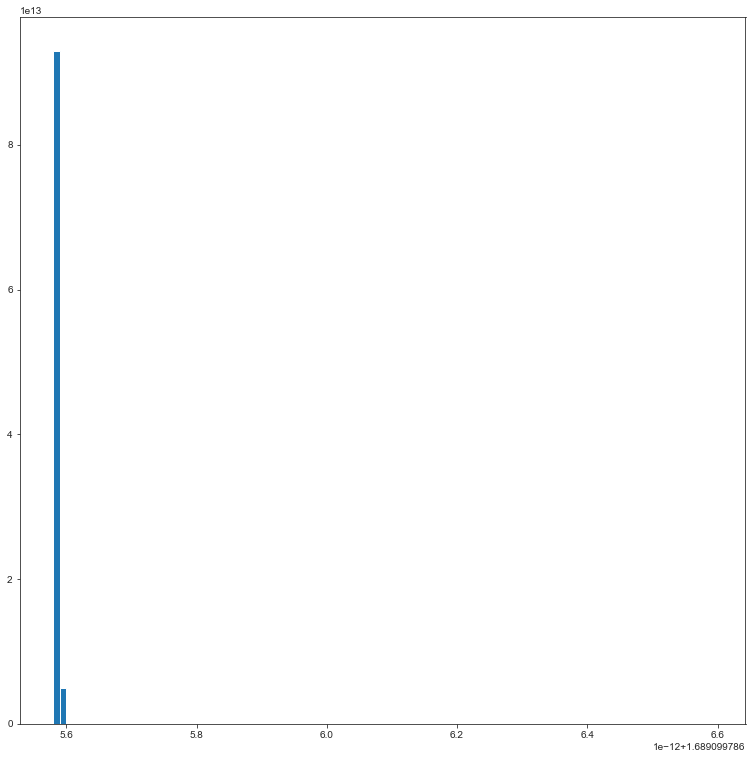

In [409]:
plt.hist(distance, bins = np.linspace(np.min(distance), np.max(distance)+1e-12, 100), density=True)

### Prediction

## Prices